## Arytmetyka komputera
###### Anna Zając


**Zadanie 1** Porównać w języku Julia reprezentację bitową liczby 1/3 dla Float16, Float32, Float64 oraz liczby, która jest inicjalizowana jako Float16, a potem rzutowana na Float64.

In [1]:
bitstring(Float16(1/3))

"0011010101010101"

In [2]:
bitstring(Float32(1/3))

"00111110101010101010101010101011"

In [39]:
bitstring(Float64(1/3))

"0011111111010101010101010101010101010101010101010101010101010101"

In [38]:
a = Float16(1/3)
bitstring(Float64(a))

"0011111111010101010101000000000000000000000000000000000000000000"


**Zadanie 2** Zbadać, jak zmienia się odległość między kolejnymi liczbami zminnoprzecinkowymi reprezentowanymi w komputerze za pomocą języka Julia. Narysować wykres używając Plots zależności odległości od wartości liczby dla zakresu od 1.0 do 1000000.0.

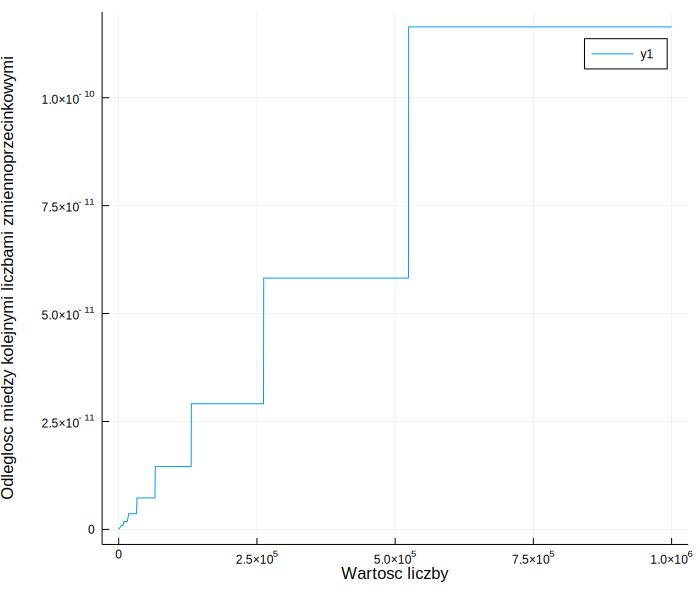

In [9]:
using Plots
y(x) = nextfloat(x)-x
plot(y,1.0,1000000.0, xlabel="Wartosc liczby", ylabel="Odleglosc miedzy kolejnymi liczbami zmiennoprzecinkowymi")
plot!(size=(700,600))

Można zauważyć, że wraz ze wzrostem wartości liczby rośnie odległość między kolejnymi liczbami zmiennoprzecinkowymi. Są to wzrosty skokowe, a odległości za każdym razem ulegają podwojeniu. Przyczyną tego jest fakt, że kiedy cecha zwiększa się o jeden, to w systemie dwójkowym mantysa jest mnożona przez liczbę dwukrotnie większą niż przed jej zwiększeniem.



**Zadanie 3** Jedną z bibliotek numerycznych, jaką będziemy używać na zajęciach jest GSL (język C). Korzystając ze wsparcia dla wyświetlania reprezentacji liczb zmiennoprzecinkowych zobaczyć jak zmienia się cecha i mantysa dla coraz mniejszych liczb. Zaobserwować, kiedy matysa przestaje być znormalizowana i dlaczego?

In [34]:
using GSL

mutable struct float32_pointer
    x::Float32
end

a = float32_pointer(1.0/100)
GSL.ieee_printf_float(pointer_from_objref(a))

 1.01000111101011100001010*2^-7

In [125]:
a = float32_pointer((1/10)^30)
GSL.ieee_printf_float(pointer_from_objref(a))

 1.01000100100001001100000*2^-100

In [123]:
a = float32_pointer((1/2)^100)
GSL.ieee_printf_float(pointer_from_objref(a))

 1.00000000000000000000000*2^-100

In [122]:
a = float32_pointer((1/2)^127)
GSL.ieee_printf_float(pointer_from_objref(a))

 0.10000000000000000000000*2^-126

Dla reprezentacji liczb zmiennoprzecinkowych na 32 bitach manstysa przestaje być znormalizowana, kiedy cecha osiągnie wartość -126, czyli swoją wartość minimalną (jest reprezentowana na 8 bitach). Żeby móc przedstawić mniejsze wartości, denormalizowana jest mantysa.

In [126]:
mutable struct float64_pointer
    x::Float64
end

b = float64_pointer((1/2)^127)
GSL.ieee_printf_double(pointer_from_objref(b))

 1.0000000000000000000000000000000000000000000000000000*2^-127

Dla reprezentacji liczb zmiennoprzecinkowych na 64 bitach liczba, która przy reprezenatcji 32 bitowej miała zdenormalizowaną mantysę, ma mantysę znormalizowaną. Cecha dla tej reprezentacji reprezentowana jest na 11 bitach, więc jej wartość minimalna to -1022.

In [127]:
a = float64_pointer((1/2)^1023)
GSL.ieee_printf_double(pointer_from_objref(a))

 0.1000000000000000000000000000000000000000000000000000*2^-1022

Kiedy cecha przekroczy minimalną wartość -1022, mantysa staje się zdenormalizowana, aby można było przedstawić mniejsze wartości.

**Zadanie 4** Na przykładzie wybranego algorytmu niestabilnego numerycznie:

1. Pokazać, że działa źle.
2. Pokazać które konkretnie działania powodują zwiększenie błędu (np. dzielenie przez małą liczbę, cancellation).
3. Zademonstować wersję stabilną.

Rozważmy problem wyliczania kolejnych wyrażeń ciągu $y_{n}$ dla liczb rzeczywistych, gdzie
$$y_{n} = \int_{0}^{1} \frac{x^n}{x+9} dx $$
Dla 0 < x < 1 ciąg $x^n$ zmierza do 0 dla $n \to\infty$. Można więc zauważyć, że 
$$y_0>y_1>y_2>...>y_n>y_{n+1}>...>0$$
oraz że $y_n \to 0$ dla $n \to \infty$.
Pierwszy algorytm tworzymy w następujący sposób:
$$ y_n + 9y_{n-1} = \int_{0}^{1} \frac{x^n + 9x^{n-1}}{x+9} dx = \int_{0}^{1} x^{n-1} dx = \frac{1}{n}\ dla\ n=1,2,3,...$$
Widać więc, że algorytm będzie miał postać:
$$ y_n = \frac{1}{n} - 9y_{n-1}$$
$y_0$ możemy wyliczyć dokładnie: 
$$y_0 = \int_{0}^{1} \frac{1}{x+9} dx= ln(10) - ln(9)$$
Przeanalizujemy teraz kilka pierwszych wyrazów ciągu:

In [146]:
y_0 = log(10/9)

0.10536051565782635

In [139]:
y_1 = 1 - 9*y_0

0.06528025162834195

In [140]:
y_2 = 1/2 - 9*y_1

0.04303823860160638

In [141]:
y_3 = 1/3 - 9*y_2

0.03206566312208864

In [142]:
y_4 = 1/4 - 9*y_3

0.025540358145379527

In [143]:
y_5 = 1/5 - 9*y_4

0.021217492982343322

In [144]:
y_6 = 1/6 - 9*y_5

0.0181442157902634

In [147]:
y_7 = 1/7 - 9*y_6

-0.020440799255227765

In [148]:
y_8 = 1/8 - 9*y_7

0.3089671932970499

In [149]:
y_9 = 1/9 - 9*y_8

-2.669593628562338

Algorytm ten jest niestabilny: dla $y_7$ oraz $y_9$ wynik staje się ujemny, co nie powinno się wydarzyć nigdy. Poza tym $y_8$ jest większe od $y_7$, co również przeczy wcześniej poczynionym obserwacją.
Działaniem, które powoduje tak duży błąd, jest mnożenie przez 9 wyniku poprzedniego działania, co sprawia że dla danej iteracji błąd staje się 9-krotnie większy.
Algorytm stabilny dla tego problemu będzie miał postać:
$$ y_{n-1} = \frac{1}{n} - \frac{y_n}{9}$$
Teraz w każdej iteracji błąd z poprzednich działań powinien zmniejszać się dziewięciokrotnie.
Jeśli $y_{10} \approx \frac{9}{1000}$:

In [170]:
y_9 = 1/9*(1/10-9/1000)

0.010111111111111112

In [171]:
y_8 = 1/9*(1/9 - y_9)

0.01122222222222222

In [173]:
y_7 = 1/9*(1/8 - y_8)

0.012641975308641975

In [174]:
y_6 = 1/9*(1/7 - y_7)

0.01446835194983343

In [177]:
y_5 = 1/9*(1/6 - y_6)

0.016910923857425913

In [178]:
y_4 = 1/9*(1/5 - y_5)

0.020343230682508234

In [179]:
y_3 = 1/9*(1/4 - y_4)

0.025517418813054638

In [186]:
y_2 = 1/9*(1/3 - y_3)

0.034201768280030964

In [187]:
y_1 = 1/9*(1/2 - y_2)

0.05175535907999656

In [188]:
y_0 = 1/9*(1 - y_1)

0.10536051565777815

Jak widać, $y_0$ zgadza się z wartością analityczną z dokładnością do 12 miejsc po przecinku.